In this file we will tune and build machine learning models from the data made in the feature_extraction file

**Importing libraries**

In [2]:
import random
import os
import numpy as np
# had to uses pip to install librosa
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, recall_score, make_scorer
from scikitplot.metrics import plot_confusion_matrix 
from scipy.io import wavfile as wav
from librosa.feature import mfcc
import pickle
from tqdm import tqdm
import inspect
import pandas as pd
import re

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

Setting path variable:

In [2]:
path = os.getcwd() + '\\data\\'
print(path)

c:\Users\Emili\DSIM_project\VER\data\


## **Loading data**

In [7]:
def load_data(feature_extractor, train_size=0.8):
  
  # Note: train size must be 0.8 (see preprocessing.ipynb)
  train = []
  X_train = []
  y_train = []

  test = []
  X_test = []
  y_test = []
  
  unauth_split = train_size/(23-22*train_size)

  random.seed(10) # For reproducibility

  
  # Authorized speaker
  track_num = 0
  tracks = os.listdir(path + 'auth_speaker')
  random.shuffle(tracks)
  for track in tracks:
    track_num = track_num + 1
    _, signal = wav.read(path + 'auth_speaker\\' + track)
    if track_num <=np.floor(train_size*len(tracks)):
      train.append((feature_extractor(signal), 'authorized'))
    else:
        test.append((feature_extractor(signal), 'authorized'))
        
  # Impostor speaker
  for speaker in os.listdir(path + 'unauth_speakers'):
    track_num = 0
    tracks = os.listdir(path + 'unauth_speakers\\' + speaker)
    random.shuffle(tracks)
    for track in tracks:
      track_num = track_num + 1
      _, signal = wav.read(path + 'unauth_speakers\\' + speaker + '\\' + track)
      if track_num <=np.floor(unauth_split*len(tracks)):
        train.append((feature_extractor(signal), 'impostor'))
      else:
        test.append((feature_extractor(signal), 'impostor'))
          
  random.shuffle(train)
  random.shuffle(test)
  
  # Separate features and labels
  X_train = [row[0] for row in train]
  y_train = [row[1] for row in train]
  X_test = [row[0] for row in test]
  y_test = [row[1] for row in test]


  # Normalize          
  eps = 0.001
  X_train = np.array(X_train)
  X_train_mean = X_train.mean(axis=0)
  X_train_std = X_train.std(axis=0)
  X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
  X_train = [row for row in X_train]
  X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]


  return X_train, X_test, y_train, y_test

def feats_mfcc(input, rate = 8000):
  input = mfcc(y = input*1.0, sr = rate)
  output = input.flatten()
  return output

def zcr (input):
  k=0
  for i in range(0, len(input)-1):
    if input[i]*input[i+1]<0:
      k=k+1

  return np.array(k, ndmin = 1)

def standard_dev(input):
    return np.std(input, keepdims=True)
  
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)
  
def combo(input):
  return np.concatenate((standard_dev(input),energy(input), zcr(input),
                         feats_mfcc(input)))

In [8]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, train_size=0.8)

In [9]:
print('Train set instances:', len(y_train), '\tAuthorized:',
      y_train.count('authorized'), '\tImpostor:', y_train.count('impostor'))
print('Test set instances:', len(y_test), '\tAuthorized:',
      y_test.count('authorized'), '\tImpostor:', y_test.count('impostor'))

Train set instances: 2269 	Authorized: 1142 	Impostor: 1127
Test set instances: 6864 	Authorized: 286 	Impostor: 6578


As we wanted, the train set is balanced between authorized vs impostor while the test set is balanced between speakers (authorized speaker instances = impostor speaker instances for each speaker, although with the code above we can only confirm that the impostor class is 23 times more represented than the authorized class)

Saving datasets as pickle files in case we want to re-run stuff without having to load the data again with the previous function

In [32]:
def save_as_pickle(file, path):
  with open(path, "wb") as fp:
    pickle.dump(file, fp)
    
if not os.path.isdir(os.getcwd() + '\\train_test_data'):
  os.mkdir(os.getcwd() + '\\train_test_data')

names = ['X_train', 'X_test', 'y_train', 'y_test']
i = 0
for file in [X_train, X_test, y_train, y_test]:
  save_as_pickle(file, os.getcwd() + '\\train_test_data\\' + names[i] + '.pkl')
  i = i + 1

This is how they're loaded from the pickle files:

In [5]:
with open(os.getcwd() + '\\train_test_data\\X_train.pkl', "rb") as fp:   # Unpickling
    X_train = pickle.load(fp)
with open(os.getcwd() + '\\train_test_data\\y_train.pkl', "rb") as fp:   # Unpickling
    y_train = pickle.load(fp)
with open(os.getcwd() + '\\train_test_data\\X_test.pkl', "rb") as fp:   # Unpickling
    X_test = pickle.load(fp)
with open(os.getcwd() + '\\train_test_data\\y_test.pkl', "rb") as fp:   # Unpickling
    y_test = pickle.load(fp)

## **Validation on classifier models**
We decided to try a few classifiers in the skleqrn library to see which one would be the best for our data. We will use the validation set to see which one is the best and keep the default hyperparameters for now. The performance criteria will be recall on the impostor class since for the verification task the most important thing is that we don't let impostors in.

In [164]:
def try_classifiers(X, Y, classifiers, dest_path, random_state, split):
    
    performances = {}
    
    
    # Splitting the set for validation
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = split, random_state = random_state)

    print('Train2 instances', len(Y_train), 'Authorized:', Y_train.count('authorized'),
          'Impostor:', Y_train.count('impostor'))
    print('Validation instances', len(Y_val), 'Authorized:', Y_val.count('authorized'),
            'Impostor:', Y_val.count('impostor'))

    for classifier in tqdm(classifiers):
        
        if classifier.__name__ == 'XGBClassifier':
            print('data format changed\n')
            X_train = pd.DataFrame(np.row_stack(X_train))
            X_val = pd.DataFrame(np.row_stack(X_val))
            Y_train = pd.DataFrame(np.row_stack(Y_train))
            for i in range(len(Y_train.loc[:,0])):
                if Y_train.loc[i,0]=='authorized':
                    Y_train.loc[i,0] = 1
                elif Y_train.loc[i,0]=='impostor':
                    Y_train.loc[i,0] = 0
            Y_train = Y_train.astype('str').astype('int')
            
            Y_val = pd.DataFrame(np.row_stack(Y_val))
            for i in range(len(Y_val.loc[:,0])):
                if Y_val.loc[i,0]=='authorized':
                    Y_val.loc[i,0] = 1
                elif Y_val.loc[i,0]=='impostor':
                    Y_val.loc[i,0] = 0
            Y_val = Y_val.astype('str').astype('int')

        print('Training', classifier.__name__)

        # If classifier has random_state parameter, set it to random_state
        if 'random_state' in inspect.signature(classifier).parameters:
            estimator = classifier(random_state = random_state)
        else:
            estimator = classifier()
    
        estimator.fit(X_train, Y_train)    
        predictions = estimator.predict(X_val)   
    
        train_acc = estimator.score(X_train, Y_train)
        if classifier.__name__ == 'XGBClassifier':
            val_impostor_recall = recall_score(Y_val, predictions, pos_label=0)
        else:
            val_impostor_recall = recall_score(Y_val, predictions, pos_label='impostor')

        performances[classifier.__name__] = [train_acc, val_impostor_recall]

    perf_df = pd.DataFrame.from_dict(performances, orient = 'index',
                                     columns = ['train2 acc', 'val impostor recall'])

    perf_df = perf_df.sort_values(by = ['val impostor recall'], ascending = False)
    

    perf_df.to_csv(dest_path, index = True) # Needs to be opened with index_col = 0

    
    return 'Performances saved successfully'

In [165]:
classifiers = [LogisticRegression, RidgeClassifier, GaussianNB,
               LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis, RandomForestClassifier,
               KNeighborsClassifier, NearestCentroid, XGBClassifier]
dest_path = os.getcwd() + '\\classifiers_summary.csv'
random_state = 10

print('Trying out different classifiers')
print(try_classifiers(X_train, y_train, classifiers, dest_path, random_state, 0.3))

Trying out different classifiers
Train2 instances 1588 Authorized: 795 Impostor: 793
Validation instances 681 Authorized: 347 Impostor: 334


  0%|          | 0/9 [00:00<?, ?it/s]

Training LogisticRegression


 11%|█         | 1/9 [00:00<00:04,  1.82it/s]

Training RidgeClassifier


 22%|██▏       | 2/9 [00:00<00:03,  2.17it/s]

Training GaussianNB


 33%|███▎      | 3/9 [00:01<00:02,  2.26it/s]

Training LinearDiscriminantAnalysis


 44%|████▍     | 4/9 [00:05<00:09,  1.85s/it]

Training QuadraticDiscriminantAnalysis


c:\Users\Emili\miniconda3\envs\DSIM\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
 56%|█████▌    | 5/9 [00:07<00:08,  2.02s/it]

Training RandomForestClassifier


 67%|██████▋   | 6/9 [00:18<00:14,  4.87s/it]

Training KNeighborsClassifier


 78%|███████▊  | 7/9 [00:18<00:06,  3.41s/it]

Training NearestCentroid
data format changed

Training XGBClassifier


100%|██████████| 9/9 [00:29<00:00,  3.30s/it]

Performances saved successfully


In [166]:
pd.read_csv(dest_path, index_col = 0)

,train2 acc,val impostor recall
KNeighborsClassifier,0.953401,0.961078
LogisticRegression,1.000000,0.940120
XGBClassifier,1.000000,0.892216
RandomForestClassifier,1.000000,0.841317
LinearDiscriminantAnalysis,0.997481,0.820359
RidgeClassifier,1.000000,0.805389
GaussianNB,0.882872,0.754491
NearestCentroid,0.870907,0.721557
QuadraticDiscriminantAnalysis,1.000000,0.577844


Picked the following classifiers:
- KNN: best impostor recall on validation set
- Gaussian Naive Bayes: least overfitting on train set

## **K Nearest Neighbors**

### **Hyperparameter tuning**

We will use the following hyperparameters:

- n_neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 20, 25, 30, 35, 40, 45, 50]
- weights = ['uniform', 'distance']
- algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
- leaf_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
- p = [1, 2]

Since this model doesn't have many hyperparameters and its computationally cheap, we will use cross validation to tune them

In [5]:
hyperparameters = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 20, 25, 30, 35, 40, 45, 50],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
    }

In [ ]:
knn = KNeighborsClassifier()
impostor_recall = make_scorer(recall_score, pos_label='impostor')
clf = GridSearchCV(knn, hyperparameters, scoring = impostor_recall, n_jobs=-1, cv=5, verbose=1)
clf.fit(X_train, y_train)

In [170]:
clf.best_params_

{'algorithm': 'auto', 'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}

### **Tuned Model**
Fitting model with optimal parameters:

In [10]:
knn_tuned = KNeighborsClassifier(n_neighbors=25, algorithm='auto', p=2,
                            weights='uniform')
knn_tuned.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

**Performances:**

In [11]:
print(f"\nAccuracy on train set: {knn_tuned.score(X_train, y_train)}")


Accuracy on train set: 0.9510797708241516


In [12]:
predictions_tuned = knn_tuned.predict(X_test)

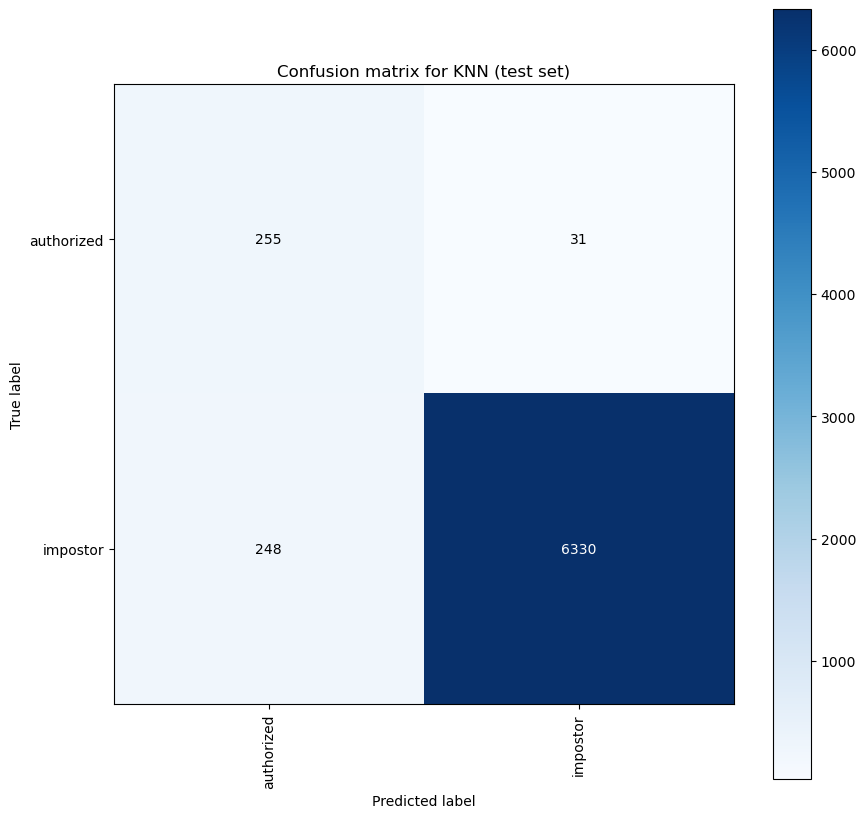

In [13]:
plot_confusion_matrix(y_test, predictions_tuned, x_tick_rotation=90, figsize=(10,10),
                      title='Confusion matrix for KNN (test set)');

In [11]:
def get_classification_report(y_test, y_pred):

    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.round(3)
    df_classification_report = df_classification_report.drop(['weighted avg'])
    df_classification_report['support'] = df_classification_report['support'].astype(int)
    df_classification_report['accuracy'] = np.nan
    df_classification_report = df_classification_report[['accuracy', 'precision', 'recall', 'f1-score', 'support']]
    df_classification_report['accuracy']['macro avg']= df_classification_report['precision']['accuracy']
    df_classification_report = df_classification_report.drop(['accuracy'], axis=0)
    df_classification_report.rename({'macro avg': 'average'}, axis=0, inplace=True)
    return df_classification_report

In [12]:
classification_report_knn_tuned = get_classification_report(y_test, predictions_tuned)
print('\nClassification report for KNN (test set):')
classification_report_knn_tuned


Classification report for KNN (test set):


,accuracy,precision,recall,f1-score,support
authorized,NaN,0.507,0.892,0.646,286
impostor,NaN,0.995,0.962,0.978,6578
average,0.959,0.751,0.927,0.812,6864


As we can see even the model is performing well overall. It has low precision for the authorized class on the test set because that class is underrepresented in the test set (only 1/24 of the test set is made of authorized instances, as it should). The important thing is that there few false positives (only 4% of the impostor instances are classified as authorized), i.e. high recall for the impostor class (**0.962**).

**ATTENTION:** while we managed to create a train set and test set that are balanced in a different way in the preprocessing file, we didn't manage to do the same for the validation set. This means that the validation set is still balanced between authorized and impostor instances, but not between speakers. This means that the validation set is not representative of the test set, and therefore the performances on the validation set are not representative of the performances on the test set. This means that the best parametrs chosen by the validation process may not be the best parameters for the test set scenario, where the impostor class is 23 times more represented than the authorized class. It's worth then checking the test set performances on the model trained with default parameters.

### **Default Model**

In [13]:
knn_default = KNeighborsClassifier()
knn_default.fit(X_train, y_train)

predictions_default = knn_default.predict(X_test)

In [14]:
recall_score(y_test, predictions_default, pos_label='impostor')

0.9571298266950441

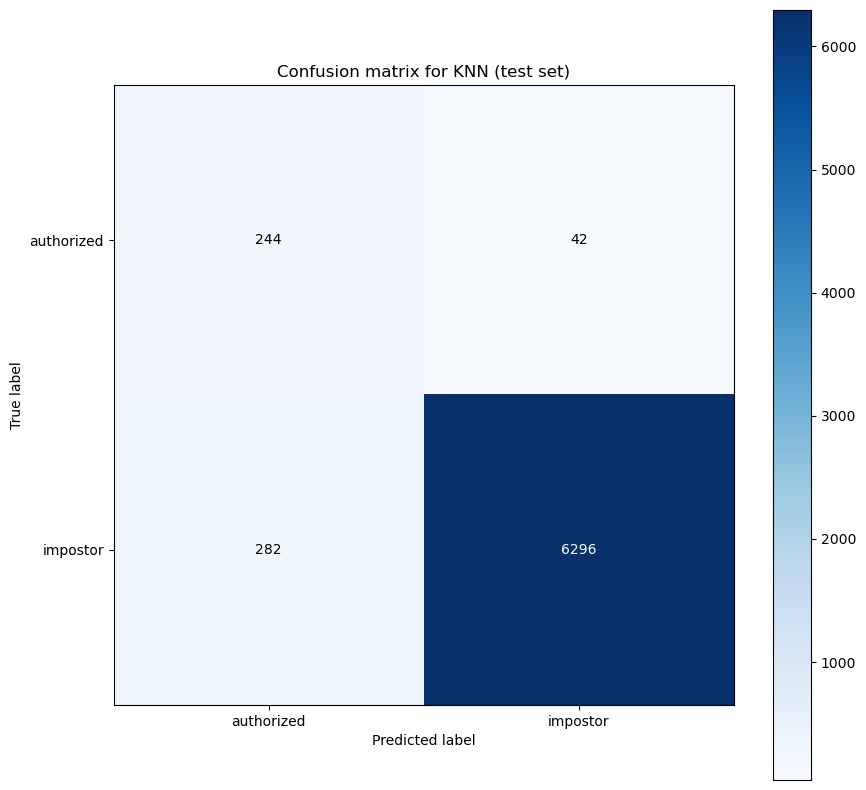

In [15]:
plot_confusion_matrix(y_test, predictions_default, figsize=(10,10),
                      title='Confusion matrix for KNN (test set)');

In [18]:
classification_report_knn_default = get_classification_report(y_test, predictions_default)
print('\nClassification report for KNN (test set):')
classification_report_knn_default


Classification report for KNN (test set):


,accuracy,precision,recall,f1-score,support
authorized,NaN,0.464,0.853,0.601,286
impostor,NaN,0.993,0.957,0.975,6578
average,0.953,0.729,0.905,0.788,6864


### **Final Model**

As we can see the **tuned model** performes better in every metric also on the test set.

In [20]:
classification_report_knn_tuned.to_csv(os.getcwd() + '\\KNN_performances.csv',
                                index = True)
# Has to be read with index_col = 0

In [19]:
pickle.dump(knn_tuned, open(os.getcwd() + '\\KNN.sav', 'wb'))

## **Gaussian Naive Bayes**

### **Hyperparameter tuning**

 We will use the following hyperparameters:

- 'var_smotthing': [1,...,1e-09] in a logarithmic scale

Since this model doesn't have many hyperparameters and its computationally cheap, we will use cross validation to tune them

In [184]:
hyperparameters = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [187]:
gnb = GaussianNB()
impostor_recall = make_scorer(recall_score, pos_label='impostor')
clf = GridSearchCV(gnb, hyperparameters, scoring = impostor_recall, n_jobs=-1, cv=5, verbose=1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring=make_scorer(recall_score, pos_label=impostor), verbose=1)

In [189]:
clf.best_params_

{'var_smoothing': 0.0002848035868435802}

### **Tuned model**
Fitting model with optimal parameters:

In [21]:
gnb_tuned = GaussianNB(var_smoothing=0.0002848035868435802)
gnb_tuned.fit(X_train, y_train)

GaussianNB(var_smoothing=0.0002848035868435802)

**Performances:**

In [22]:
print(f"\nAccuracy on train set: {gnb_tuned.score(X_train, y_train)}")


Accuracy on train set: 0.8854120758043191


In [23]:
predictions_tuned = gnb_tuned.predict(X_test)

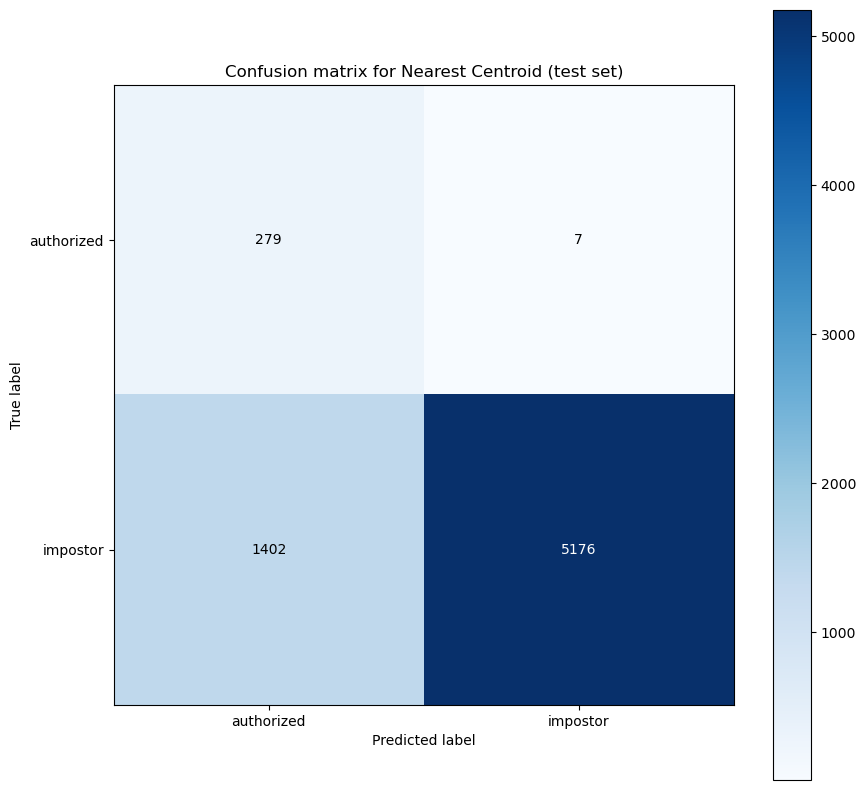

In [24]:
plot_confusion_matrix(y_test, predictions_tuned, figsize=(10,10),
                      title='Confusion matrix for Nearest Centroid (test set)');

In [25]:
classification_report_gnb_tuned = get_classification_report(y_test, predictions_tuned)
print('\nClassification report for GNB (test set):')

classification_report_gnb_tuned


Classification report for GNB (test set):


,accuracy,precision,recall,f1-score,support
authorized,NaN,0.166,0.976,0.284,286
impostor,NaN,0.999,0.787,0.880,6578
average,0.795,0.582,0.881,0.582,6864


As we can see performances are worse than the other classifier's. This is probably due to the fact that the features are not independent from each other, which is one of the assumptions of the Naive Bayes classifier. While it achieves slighlty better recall on the authorized class (how many times the authorized user was recognized as such) its precision on the authorized class is much worse. This model still guarantees a decent recall for the impostor class (**0.787**), which is the most important thing.

As done for the KNN model, we will check the performances on the test set with default parameters.

### **Default model**

In [26]:
gnb_default = GaussianNB()
gnb_default.fit(X_train, y_train)

predictions_default = gnb_default.predict(X_test)

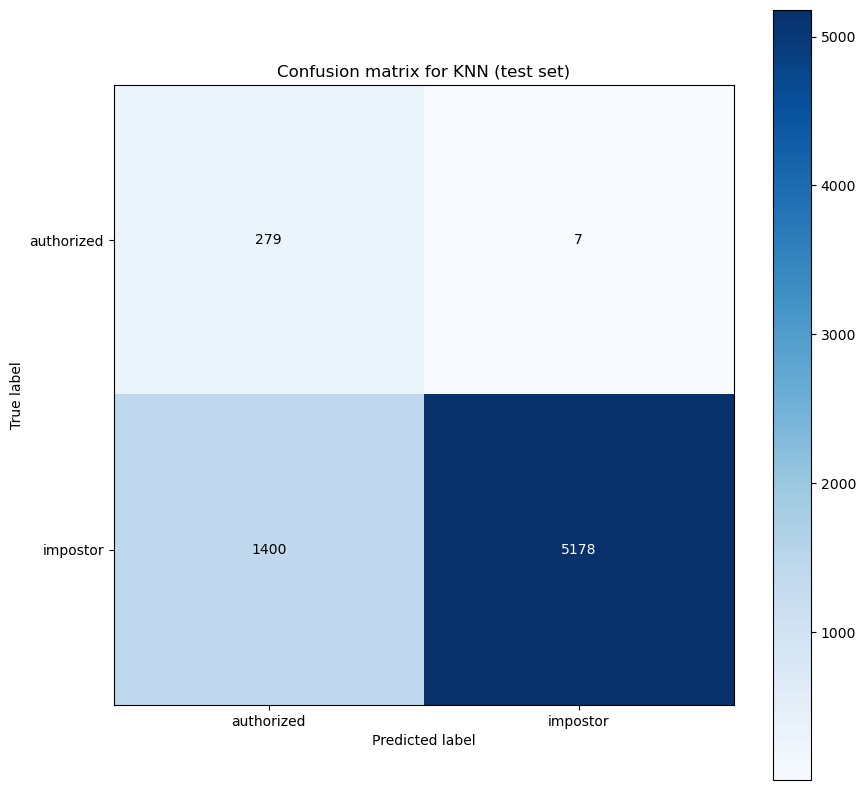

In [27]:
plot_confusion_matrix(y_test, predictions_default, figsize=(10,10),
                      title='Confusion matrix for KNN (test set)');

In [28]:
classification_report_gnb_default = get_classification_report(y_test, predictions_default)
print('\nClassification report for GNB (test set):')
classification_report_gnb_default


Classification report for GNB (test set):


,accuracy,precision,recall,f1-score,support
authorized,NaN,0.166,0.976,0.284,286
impostor,NaN,0.999,0.787,0.880,6578
average,0.795,0.582,0.881,0.582,6864


### **Final model**

The default and tuned version are practically identical. We select the default model just because it has 2 more impostors correctly classified.

In [30]:
classification_report_gnb_default.to_csv(os.getcwd() + '\\GNB_performances.csv', index = True)
# Has to be read with index_col = 0

In [31]:
pickle.dump(gnb_default, open(os.getcwd() + '\\GNB.sav', 'wb'))